In [1]:
# Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn
import scipy as sp
# from numba import jit, cuda
# from timeit import default_timer as timer

In [2]:
# Calculating Cumulative Count Cut
def scaleCCC(x):
  return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def readAsArray(img):
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img.GetRasterBand(1).ReadAsArray()
  band8 = img.GetRasterBand(2).ReadAsArray()
  band12 = img.GetRasterBand(3).ReadAsArray()
  # Creating a new image by combining the three bands
  return(np.dstack((band4, band8, band12)))

def applyCCC(img):
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img.GetRasterBand(1).ReadAsArray()
  band8 = img.GetRasterBand(2).ReadAsArray()
  band12 = img.GetRasterBand(3).ReadAsArray()
  ccc4 = scaleCCC(band4)
  ccc8 = scaleCCC(band8)
  ccc12 = scaleCCC(band12)
  # Creating a new image by combining the three bands
  return(np.dstack((ccc4,ccc8,ccc12)))

In [3]:
# Reshaping the images
def reshape_images():
  reshaped_images=[]
  for i in range(len(images)):
    new_shape = (images[i].shape[0] * images[i].shape[1], images[i].shape[2])
    new_image = images[i][:, :, :3].reshape(new_shape)
    reshaped_images.append(new_image)

  # Concatenating all the arrays
  combined_image = reshaped_images[0]
  for i in range(1, len(reshaped_images)):
    combined_image = np.concatenate((combined_image, reshaped_images[i]), axis=0)

  # Removing nan values
  train_image = np.nan_to_num(combined_image)
  return train_image

In [4]:
# Reshaping the images
def reshape_all_images():
  reshaped_images=[]
  for i in range(len(all_images)):
    new_shape = (all_images[i].shape[0] * all_images[i].shape[1], all_images[i].shape[2])
    new_image = all_images[i][:, :, :3].reshape(new_shape)
    reshaped_images.append(new_image)

  # Concatenating all the arrays
  combined_image = reshaped_images[0]
  for i in range(1, len(reshaped_images)):
    combined_image = np.concatenate((combined_image, reshaped_images[i]), axis=0)

  # Removing nan values
  train_image = np.nan_to_num(combined_image)
  return train_image

In [5]:
# Defining Plot Function

def plot_image(plt_img):
  plt.figure()
  plt.imshow(plt_img)
  plt.show()

In [6]:
# normal function to run on cpu
# def cpu_dbscan(model, trn_img):
# 	return model.fit(trn_img)

# function optimized to run on gpu
# @jit(target_backend='cuda', forceobj=True)
def dbscan(model, trn_img):
	return model.fit(trn_img)
	# 	return model.fit(trn_img)

In [32]:
# Running the DBSCAN Algorithm
dbscan_model = DBSCAN(eps=0.009554383, min_samples=40)
all_images_list=[]
all_images=[]
for i in range(3,4):
  # List of images
  images_list=[str(i)+ "_P_256.tif", str(i) +"_A_256.tif"]
  images = []
  # Opening the satellite images
  for img_name in images_list:
    img = gdal.Open('./ALL_FLOOD_256/'+ img_name)
    og_img = readAsArray(img)
    all_images_list.append(og_img)
    modified_img = applyCCC(img)
    images.append(modified_img)
  all_images.extend(images)
  train_image = reshape_images()
  all_train_image = reshape_all_images()
  dbscan_model = dbscan(dbscan_model, train_image)

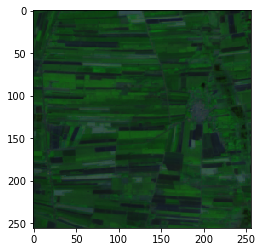

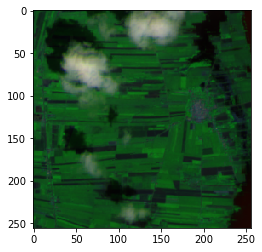

In [8]:
# Visualizing all the images 
for img in all_images_list:
  plot_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


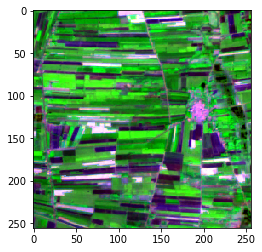

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


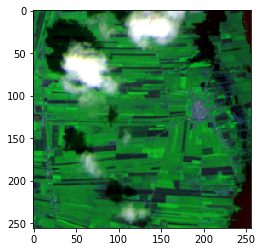

In [9]:
# Visualizing all the images after applying CCC
for img in all_images:
  plot_image(img)

In [10]:
# Opening the test images
imgP = gdal.Open("./ALL_FLOOD_256/2_P_256.tif")
imgA = gdal.Open("./ALL_FLOOD_256/2_A_256.tif")

before_img = applyCCC(imgP)
after_img = applyCCC(imgA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


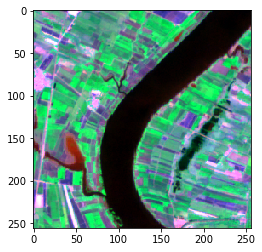

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


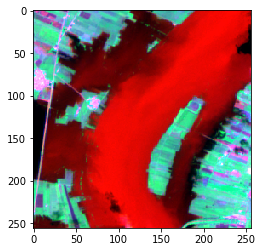

In [11]:
# Visualizing the before and after food images
plot_image(before_img)
plot_image(after_img)

In [12]:
# Reshaping the test images

new_before_shape = (before_img.shape[0] * before_img.shape[1], before_img.shape[2])
X_before = before_img[:, :, :3].reshape(new_before_shape)

new_after_shape = (after_img.shape[0] * after_img.shape[1], after_img.shape[2])
X_after = after_img[:, :, :3].reshape(new_after_shape)

In [13]:
# Running DBSCAN Algorithm on test before image

dbscan_before_labels = dbscan_model.fit_predict(X_before)
dbscan_before_labels_reshaped = dbscan_before_labels.reshape(before_img[:, :, 0].shape)

In [14]:
# Running DBSCAN Algorithm on test after image

dbscan_after_labels = dbscan_model.fit_predict(X_after)
dbscan_after_labels_reshaped = dbscan_after_labels.reshape(after_img[:, :, 0].shape)

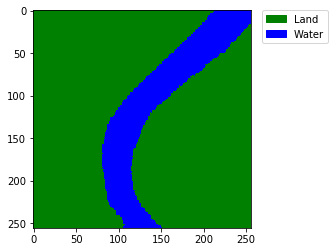

In [15]:
# Visualizing the clusters formed for pre-flood image

import matplotlib.patches as mpatches
import matplotlib.colors as colo

plt.figure()

custom = colo.ListedColormap(["green", "blue"])

im_before = plt.imshow(dbscan_before_labels_reshaped, cmap = custom)

values = np.unique(dbscan_before_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_before.cmap(im_before.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land", "Water"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

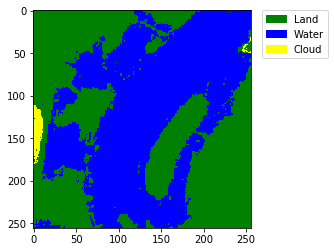

In [16]:
# Visualizing the clusters formed for post-flood image

plt.figure()

custom = colo.ListedColormap(["green", "blue", "yellow"])

im_after = plt.imshow(dbscan_after_labels_reshaped, cmap = custom)

values = np.unique(dbscan_after_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_after.cmap(im_after.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land", "Water", "Cloud"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [17]:
core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
core_samples_mask[dbscan_model.core_sample_indices_] = True
labels = dbscan_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 31109


In [18]:
# Calculating water percentage for before image

arr_before = np.unique(dbscan_before_labels, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[1]/(val_before[0] + val_before[1]) * 100
print("%.2f" %water_before, "%")

17.45 %


In [19]:
# Calculating water percentage for after image
arr_after = np.unique(dbscan_after_labels, return_counts=True)
key_after, val_after = arr_after
water_after = val_after[1]/(val_after[0] + val_after[1] + val_after[2]) * 100
print("%.2f" %water_after, "%")

51.57 %


In [20]:
# Calculating Flood Increase

flood_increase = water_after - water_before
print("%.2f" %flood_increase, "%")

34.12 %


In [34]:
# Calculating silhouette score for comparision

sklearn.metrics.silhouette_score(X_after, dbscan_after_labels)

-0.16589339